In [1]:
import numpy as np
import pandas as pd
import os
from deepmd.infer import DeepPot
from glob import glob
from mlptools.io.read import read_from_dp_data, read_from_lmp_dump
from mlptools.descriptor.dp import get_descriptor_vector, get_predictions

import matplotlib.pyplot as plt
import seaborn as sns

Instructions for updating:
non-resource variables are not supported in the long term


/home/y1u0d2/anaconda3/envs/deepmd/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
/home/y1u0d2/anaconda3/envs/deepmd/lib/python3.10/site-packages/ovito/extensions/averaging.py:2: UserWarning: Did you accidentally install the OVITO package from the PyPI repository in an Anaconda/Miniconda Python interpreter using the 'pip' command? Note that this will likely lead to conflicts with existing libraries in the Anaconda environment, and loading of the OVITO module may subsequently fail with an error related to the Qt framework. In such a case, please uninstall the OVITO pip package first by running 'pip uninstall -y ovito PySide2 PySide6' and then install the OVITO for Anaconda package using the correct command: 

    conda install --strict-channel-priority -c https://conda.ovito.org -c conda-forge ovito

Visit https://w

In [2]:
path2dump = '/home/y1u0d2/result/lammps/scripts/Si/sputtering/deepmd/model26/0deg_100eV/dump.lammpstrj'
path2model = '/home/y1u0d2/result/deepmd/Si/27/graph.pb'

path2data = '/home/y1u0d2/result/deepmd/Si/27/data'
path2test = os.path.join(path2data, 'test')
path2train = os.path.join(path2data, 'train')

model = DeepPot(path2model)

all_atoms = []
for path in glob(f'{path2test}/mp*'):
    all_atoms += read_from_dp_data(os.path.join(path, 'set.000'))

for path in glob(f'{path2train}/mp*'):
    all_atoms += read_from_dp_data(os.path.join(path, 'set.000'))

2023-02-24 09:31:06.556172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 09:31:06.783105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 09:31:06.783423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 09:31:06.819249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [3]:
all_dimer = [atoms for atoms in all_atoms if atoms.structure_id =='mp-149_dimer']

In [4]:
result = []
for atoms in all_dimer:
    distance = atoms.get_atomic_distance()
    pred_energy, _, _ = get_predictions(atoms, model=model)
    result.append([distance, atoms.energy, pred_energy[0][0]])

OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-31
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 32 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #192: KMP_AFFINITY: 1 socket x 32 cores/socket x 1 thread/core (32 total cores)
OMP: Info #218: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 1 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 2 maps to socket 0 core 2 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 3 maps to socket 0 core 3 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 4 maps to socket 0 core 4 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 5 maps to socket 0 core 5 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 6 maps to socket 0 core 6 thread 0 
OMP: Info #172: KMP_AFFINITY: O

In [5]:
energy_df = pd.DataFrame(data=np.array(result), columns=['distance', 'obs', 'pred'])

In [6]:
energy_df['obs_shift'] = energy_df['obs'] + 1260.14108
energy_df['pred_shift'] = energy_df['pred'] + 1260.14108

In [7]:
energy_df = energy_df.sort_values(by='distance').reset_index(drop=True)

/tmp/ipykernel_612425/2355227799.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


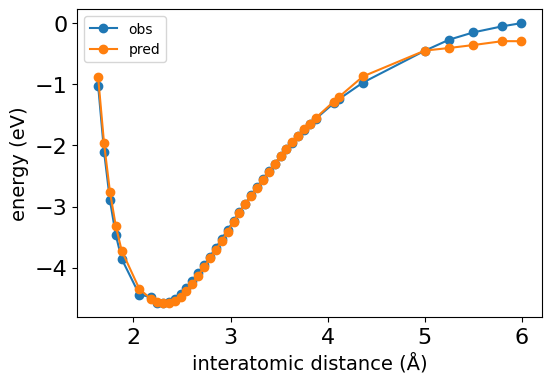

In [13]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
fs = 14

ax.plot(energy_df['distance'], energy_df['obs_shift'], label='obs', marker='o')
ax.plot(energy_df['distance'], energy_df['pred_shift'], label='pred', marker='o')

ax.legend()

ax.set_xlabel('interatomic distance (Å)', fontsize=fs)
ax.set_ylabel('energy (eV)', fontsize=fs)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

fig.show()